# EWB paper Figure 2: Observations 

We provide the exact code used to generate each figure in order to be completely reproducible and to encourage others to use EWB with their own models quickly. 
This is Figure 2, it shows all of the cases using an outline and then highlights the observations available for each inside

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.font_manager
flist = matplotlib.font_manager.get_font_names()
from tempfile import NamedTemporaryFile
from extremeweatherbench import evaluate, utils, cases, defaults
import shapely
from typing import Optional, Union, Literal
import xarray as xr
from scipy.ndimage import gaussian_filter

from pathlib import Path

# make the basepath - change this to your local path
basepath = Path.home() / 'ExtremeWeatherBench' / ''
basepath = str(basepath) + '/'

# ugly hack to load in our plotting scripts
import sys
sys.path.append(basepath + "/docs/notebooks/")
import case_plotting as cp

In [4]:
# load in all of the events in the yaml file
case_dict = utils.load_events_yaml()

# turn the dictionary into a list of case objects
ewb_cases = cases.load_individual_cases(case_dict)

# build out all of the expected data to evalate the case
# this will not be a 1-1 mapping with ewb_cases because there are multiple data sources to evaluate for some cases
# for example, a heat/cold case will have both a case operator for ERA-5 data and GHCN
case_operators = cases.build_case_operators(case_dict, defaults.get_brightband_evaluation_objects())


This function is deprecated and will be removed in a future release. Please use cases.load_ewb_events_yaml_into_case_collection instead.
This function is deprecated and will be removed in a future release. Please use cases.read_incoming_yaml instead.


In [5]:
from joblib import Parallel, delayed
from joblib.externals.loky import get_reusable_executor
# load in all the case info (note this takes awhile in non-parallel form as it has to run all the target information for each case)
# this will return a list of tuples with the case id and the target dataset

parallel = Parallel(n_jobs=8,return_as='generator',backend='loky')
case_operators_with_targets_established_generator = parallel(
    delayed(lambda co: (co.case_metadata.case_id_number, evaluate.run_pipeline(co.case_metadata, co.target)))(case_operator) 
    for case_operator in case_operators
)
case_operators_with_targets_established = list(case_operators_with_targets_established_generator)
# this will throw a bunch of errors below but they're not consequential. this releases the memory as it shuts down the workers
# now that they're not used
get_reusable_executor().shutdown(wait=True)

/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


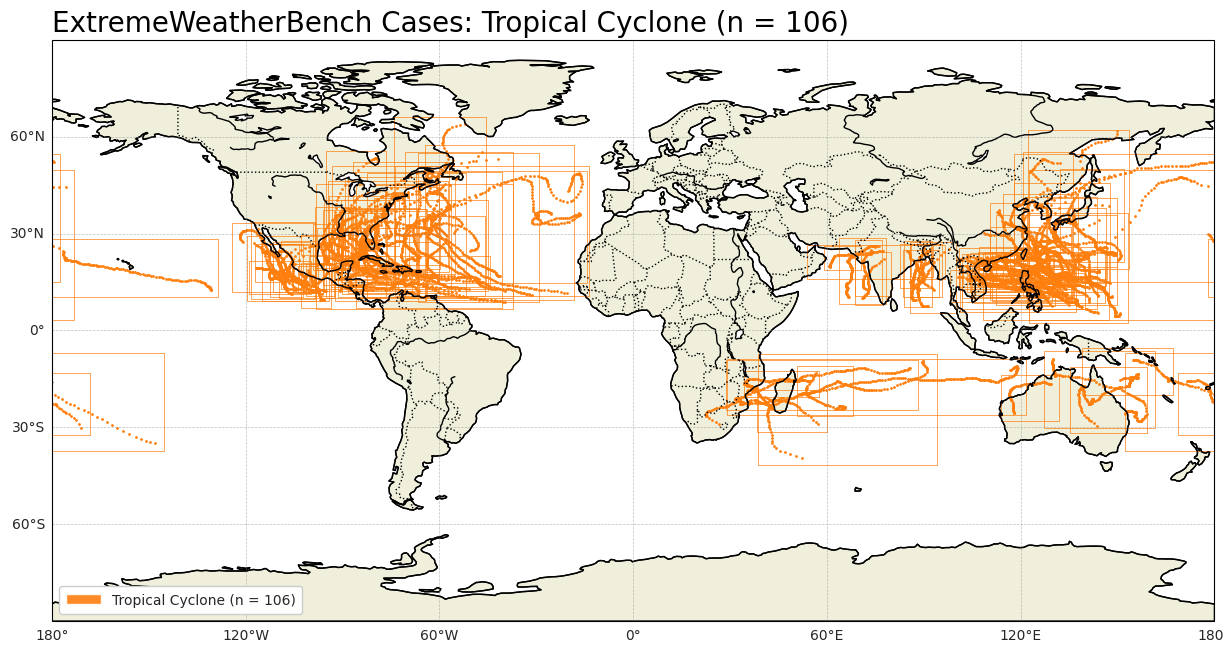

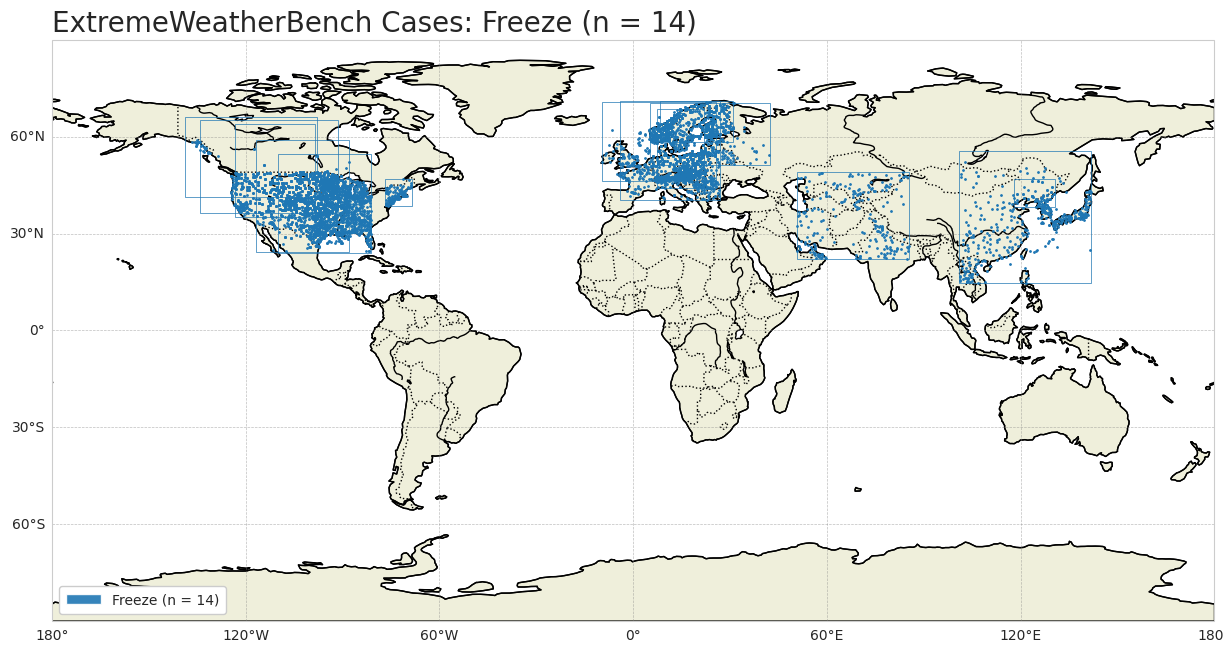

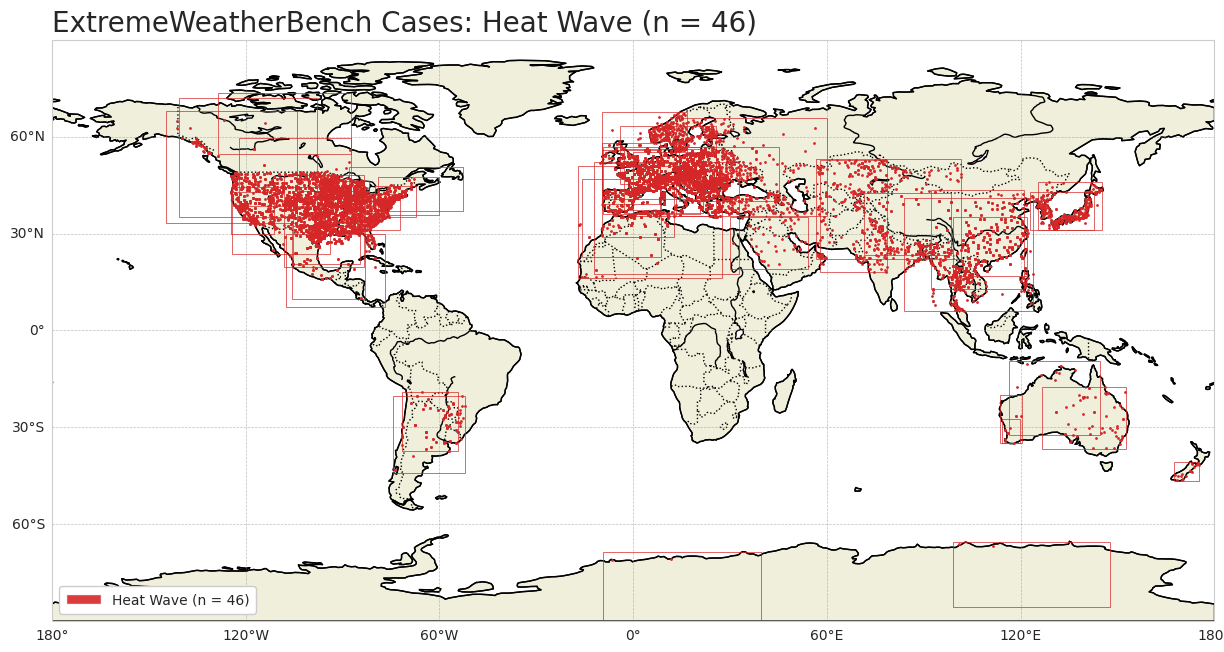

In [6]:
# plot the indivdual cases for each event type
cp.plot_all_cases_and_obs(ewb_cases, event_type='tropical_cyclone', filename='ewb_obs_tcs.png', targets=case_operators_with_targets_established)
cp.plot_all_cases_and_obs(ewb_cases, event_type='freeze', filename='ewb_obs_freeze.png', targets=case_operators_with_targets_established)
cp.plot_all_cases_and_obs(ewb_cases, event_type='heat_wave', filename='ewb_obs_heat.png', targets=case_operators_with_targets_established)
#plot_all_cases_and_obs(ewb_cases, event_type='atmospheric_river', filename=basepath + 'docs/notebooks/figs/ewb_obs_ar.png')
#plot_all_cases_and_obs(ewb_cases, event_type='severe_convection', filename=basepath + 'docs/notebooks/figs/ewb_obs_convective.png')

# # plot all cases on one giant world map
# plot_all_cases_and_obs(ewb_cases, event_type=None, filename=basepath + 'docs/notebooks/figs/ewb_obs_all.png')

In [6]:
# install metpy version 1.6.3 for this notebook only
!uv pip install metpy==1.6.3

Audited 1 package in 64ms


In [10]:
# This is modified from the original code for CONUS to work with Australian LSR data
def extract_lsr_data_australia(date: pd.Timestamp) -> pd.DataFrame:
    """Pull the latest LSR data for a given date. We pull all reorts within 1 day. If date is none, we return all reports
    
    Args:
        date: A pandas Timestamp object.
    Returns:
        df: A pandas DataFrame containing the LSR data with columns lat, lon, report_type, time, and scale.
    """

    aus_file = "gs://extremeweatherbench/datasets/AustralianLSRData_2020-2024.csv"

    # Read the CSV files with all columns to identify report types
    try:
        df = pd.read_csv(aus_file, delimiter=',', engine='python', storage_options=dict(token="anon"), parse_dates=['Date/Time UTC'], date_format='%Y-%m-%d %H:%M:%S')
    except Exception as e:
        print(f'Error pulling hail data for {date}: {e}')
        return pd.DataFrame()

    # if date is none, presumably we want all reports
    if (date == None):
        return df

    # Filter the DataFrame for the specified date range
    start_date = date - pd.Timedelta(days=0.5)    
    end_date = date + pd.Timedelta(days=0.5)
    df = df[(df['Date/Time UTC'] >= start_date) & (df['Date/Time UTC'] < end_date)]
    if len(df) == 0:
        print(f'No LSR data found for {date}')
        return pd.DataFrame()
    return df

In [11]:
def practically_perfect_hindcast_aus(
    date: pd.Timestamp,
    resolution: float = 0.25,
    report_type: Union[Literal["all"], list[Literal["tor", "hail", "wind"]]] = "all",
    sigma: float = 1.5,
    return_reports: bool = False,
    output_resolution: Optional[float] = None,
    report_constants = {'hail': 15, 'tor': 5}
) -> Union[xr.DataArray, tuple[xr.DataArray, pd.DataFrame]]:
    """Compute the Practically Perfect Hindcast (PPH) using storm report data using latitude/longitude grid spacing
    instead of the NCEP 212 Eta Lambert Conformal projection; based on the method described in Hitchens et al 2013,
    https://doi.org/10.1175/WAF-D-12-00113.1

    Args:
        date: A pandas Timestamp object.
        resolution: The resolution of the grid to use. Default is 0.25 degrees.
        report_type: The type of report to use. Default is all. Currently only supports all.
        sigma: The sigma (standard deviation) of the gaussian filter to use. Default is 1.5.
        return_reports: Whether to return the reports used to compute the PPH. Default is False.
        output_resolution: The resolution of the output grid. Default is None (keep the same resolution as the input grid).
        report_constants: A dictionary mapping report types to their respective values for the PPH grid. Default is {'hail': 15, 'tor': 5}.
    Returns:
        pph: An xarray DataArray containing the PPH around the storm report data.
    """

    df = extract_lsr_data_australia(date)
    if report_type == "all":
        pass
    else:
        df = df[df['report_type'].isin(report_type)]

    # Create a grid covering Australia
    lat_min, lat_max = -50, -10.0   
    lon_min, lon_max = 110, 180  

    # Create the grid coordinates
    grid_lats = np.arange(lat_min, lat_max + resolution, resolution)
    grid_lons = np.arange(lon_min, lon_max + resolution, resolution)

    # Initialize an empty grid
    grid = np.zeros((len(grid_lats), len(grid_lons)))

    # extract reports for TOR and HAIL separately to handle the underreporting
    for report_type in report_constants.keys():
        # Filter the dataframe for the current report type
        df2 = df[df['report_type'] == report_type]

        # Extract latitude and longitude from the dataframe
        lats = df2["Latitude"].astype(float)
        lons = df2["Longitude"].astype(float)

        # Mark grid cells that contain reports
        for lat, lon in zip(lats, lons):
            # Find the nearest grid indices
            lat_idx = np.abs(grid_lats - lat).argmin()
            lon_idx = np.abs(grid_lons - lon).argmin()
            grid[lat_idx, lon_idx] = report_constants[report_type]  # Set a value to indicate a report is present

    # Create the xarray DataArray
    pph = xr.DataArray(
        grid,
        dims=["latitude", "longitude"],
        coords={"latitude": grid_lats, "longitude": grid_lons},
        name="practically_perfect",
    )

    # Apply bilinear interpolation to smooth the field
    # First, create a gaussian kernel for smoothing
    smoothed_grid = gaussian_filter(grid, sigma=sigma)

    # Replace the data in the DataArray
    pph.data = smoothed_grid
    if output_resolution is not None:
        pph = pph.interp(latitude=np.arange(lat_min, lat_max + output_resolution, output_resolution),
                        longitude=np.arange(lon_min, lon_max + output_resolution, output_resolution),method='linear')
        pph = pph * 100
    if return_reports:
        return (pph, df)
    return pph

In [ ]:
# need to pre-compute the obs info and store it in the cases
# I think there should be either 
# 1) a quick way to grab all the metadata on the obs into the case (e.g. through a single function call at the high level) or
# 2) it is already stored into the events yaml (just the locations, but this isn't super extensible if more obs come in later)
# 3) a method call on each individual case to get the metadata
# I'm going with option 3 for now

# Note since there is about to be a big refactor of how events and cases are stored, this is just a temporary hack
events_metadata = {}
for event in cases:
    for indiv_case in event.cases:
        # this is what I want to see for each case
        # commented out because it doesn't exist :) 
        # indiv_case.get_observations_metadata()

        # instead I'll try to hack it
        if (indiv_case.event_type == 'heat_wave' or indiv_case.event_type == 'freeze'):
            # figure our how to find the obs metadata for the heat/freeze events
            #print("Help, not sure how to find the obs locations")
            continue
        elif (indiv_case.event_type == 'severe_convection'):
            # grab the LSRs and compute PPH and then we can plot both the LSRs and the PPH outer outline (up in the plotting function)

            # check if the case is inside the Australia bounding box
            bot_lat = -50
            top_lat = -10
            left_lon = 110
            right_lon = 180
            bounding_box = [left_lon, right_lon, bot_lat, top_lat]
            bounding_box_polygon = cp.get_polygon_from_bounding_box(bounding_box)

            if (shapely.intersects(indiv_case.location.geopandas.geometry[0], bounding_box_polygon)):
                print(indiv_case)
                
                pph, df = practically_perfect_hindcast_aus(indiv_case.start_date, return_reports=True)
                events_metadata[indiv_case.case_id_number] = {'pph': pph, 'lsr_reports': df}

IndividualSevereConvectionCase(case_id_number=266, title='January 2020 Australia', start_date=datetime.datetime(2020, 1, 20, 0, 0), end_date=datetime.datetime(2020, 1, 21, 0, 0), location=BoundingBoxRegion(latitude_min=-40.0, latitude_max=-10.0, longitude_min=110.0, longitude_max=155.0), event_type='severe_convection', data_vars=None, cross_listed=None, metrics_list=[<class 'extremeweatherbench.metrics.RegionalRMSE'>])
IndividualSevereConvectionCase(case_id_number=267, title='April 2020 Australia', start_date=datetime.datetime(2020, 4, 3, 0, 0), end_date=datetime.datetime(2020, 4, 4, 0, 0), location=BoundingBoxRegion(latitude_min=-40.0, latitude_max=-10.0, longitude_min=110.0, longitude_max=155.0), event_type='severe_convection', data_vars=None, cross_listed=None, metrics_list=[<class 'extremeweatherbench.metrics.RegionalRMSE'>])
IndividualSevereConvectionCase(case_id_number=268, title='May 2020 Australia', start_date=datetime.datetime(2020, 5, 31, 0, 0), end_date=datetime.datetime(202

Error stacking sparse data for 79 from dimensions latitude, longitude: 'numpy.ndarray' object has no attribute 'coords'. This is likely because the data is not available for this case.


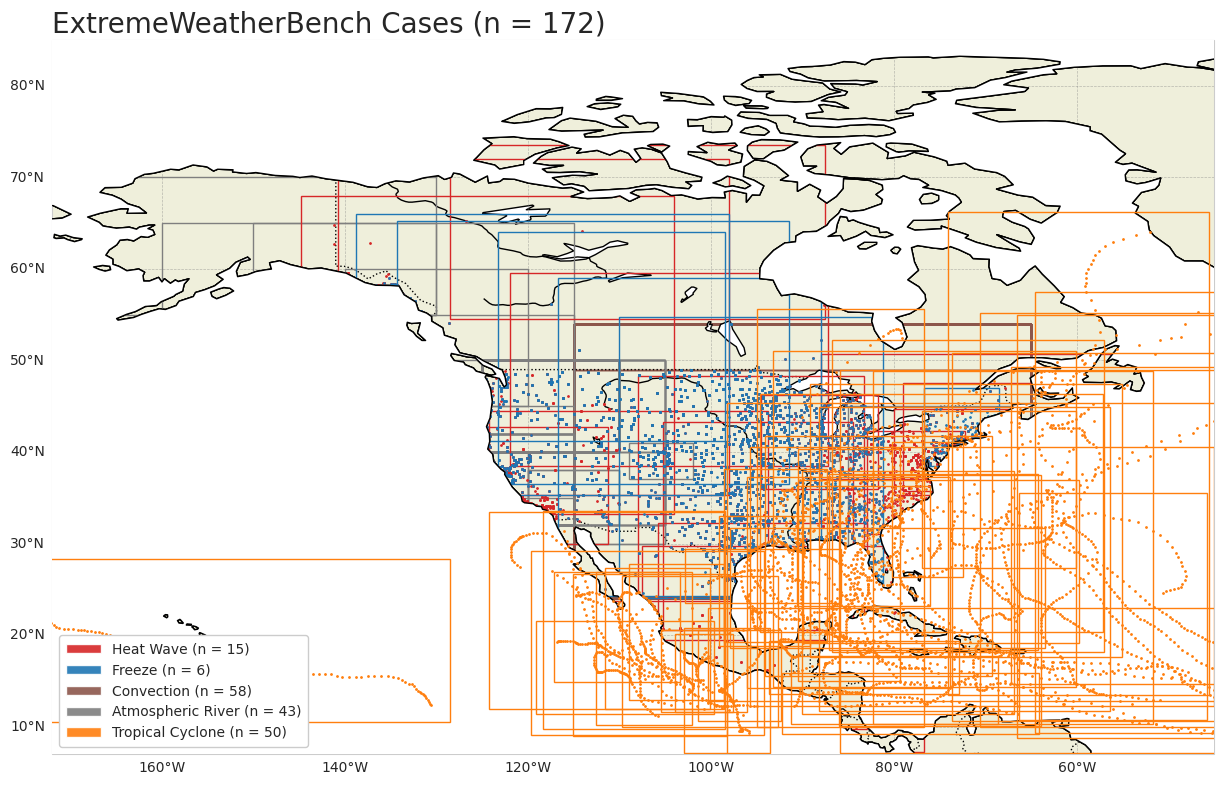

In [ ]:
# plot North America
bot_lat = 7
top_lat = 85
left_lon = -172
right_lon = -45

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in North America'

cp.plot_all_cases_and_obs(ewb_cases, event_type=None, bounding_box=bounding_box, targets=case_operators_with_targets_established)

50 -15 15 75


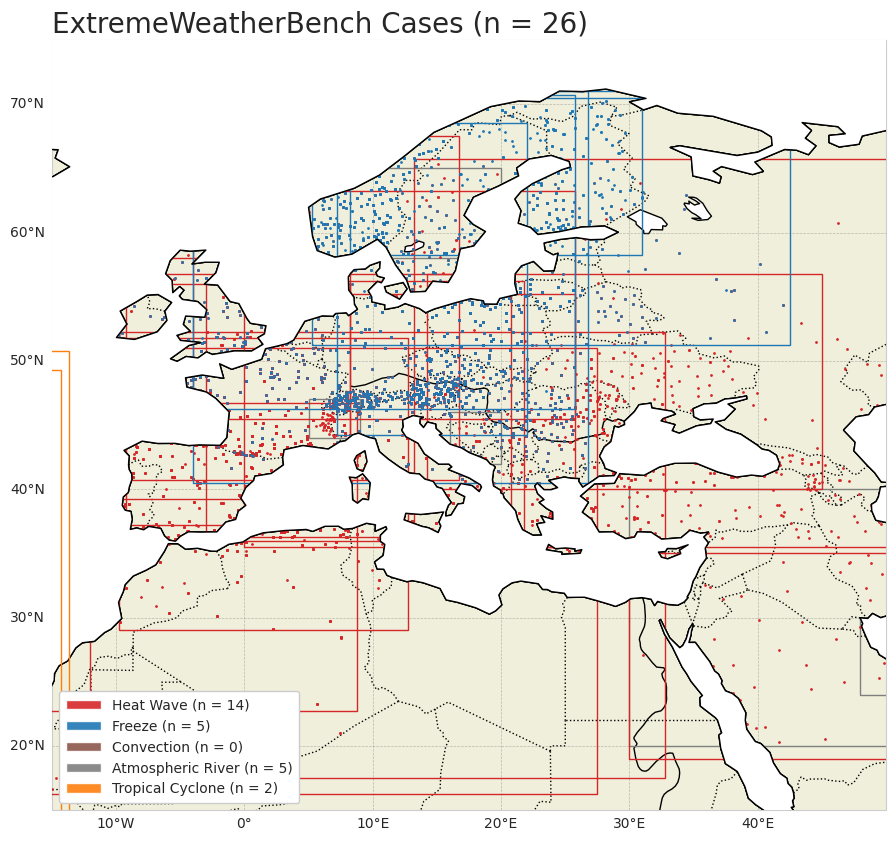

In [10]:
# plot Europe
bot_lat = 15
top_lat = 75
left_lon = -15
right_lon = 50

print(right_lon, left_lon, bot_lat, top_lat)

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in Europe'
cp.plot_all_cases_and_obs(ewb_cases, event_type=None, bounding_box=bounding_box, targets=case_operators_with_targets_established)

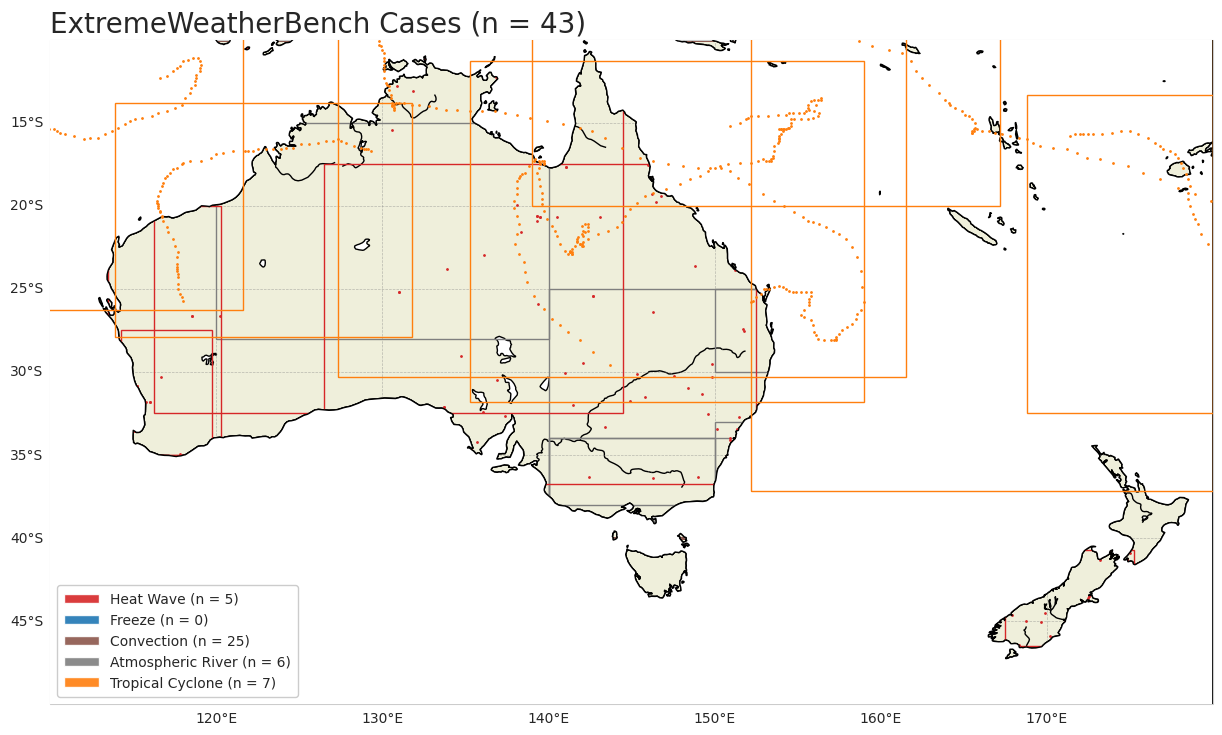

In [11]:
# plot Australia
bot_lat = -50
top_lat = -10
left_lon = 110
right_lon = 180
bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in Australia'

cp.plot_all_cases_and_obs(ewb_cases, event_type=None, bounding_box=bounding_box, targets=case_operators_with_targets_established)